In [3]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust

# import wquantiles
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
try:
    import common
    DATA = common.dataDirectory()
except:
    # DATA = Path().resolve("/home/gadamurrr/Desktop/practical-statistics-for-data-scientists") / "data"
    DATA = '/home/gadamurrr/Desktop/practical-statistics-for-data-scientists/data/'


In [34]:
AIRLINE_STATS_CSV = DATA + 'airline_stats.csv'
KC_TAX_CSV = DATA + 'kc_tax.csv.gz'
LC_LOANS_CSV = DATA + 'lc_loans.csv'
AIRPORT_DELAYS_CSV = DATA + 'dfw_airline.csv'
SP500_DATA_CSV = DATA + 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA + 'sp500_sectors.csv'
STATE_CSV = DATA + 'state.csv'

# Оценки местоположения населения и уровня убийств

In [36]:
state = pd.read_csv(STATE_CSV)
state.head(5)

,State,Population,Murder.Rate,Abbreviation
0,Alabama,4779736,5.7,AL
1,Alaska,710231,5.6,AK
2,Arizona,6392017,4.7,AZ
3,Arkansas,2915918,5.6,AR
4,California,37253956,4.4,CA


# вычислить среднее, среднее усеченное и медиану (Population)

In [37]:
state["Population"].mean()

6162876.3

In [38]:
state["Population"].median()

4436369.5

In [39]:
trim_mean(state["Population"], 0.1)

4783697.125

# взвешанная медиана

In [40]:
np.average(state["Murder.Rate"], weights=state["Population"])

4.445833981123393

# Оценки изменчивости

# найти стандартное отконение и межквартильный размах

In [41]:
state["Population"].std()

6848235.347401142

In [42]:
state["Population"].quantile(0.75) - state["Population"].quantile(0.25)

4847308.0

# Абсолютное отклонение медианы от медианы можно рассчитать с помощью метода в statsmodels

In [45]:
robust.scale.mad(state["Population"])

3849876.1459979336

In [46]:
abs(state["Population"] - state["Population"].median()).median() / 0.6744897501960817

3849876.1459979336

# Перцентили и box-plot

In [48]:
state["Murder.Rate"].quantile([0.05, 0.25, 0.5, 0.75, 0.95])

0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64

In [55]:
percentiles = [0.05, 0.25, 0.5, 0.75, 0.95]
df = pd.DataFrame(state["Murder.Rate"].quantile(percentiles))
df.index = [f"{int(p * 100)}%" for p in percentiles]
df.transpose()

,5%,25%,50%,75%,95%
Murder.Rate,1.6,2.425,4.0,5.55,6.51


# 5%-й квантиль – Значение, ниже которого лежит 5% данных.

# Если 5% = 1.2, значит, в 5% штатов уровень убийств ≤ 1.2 на 100 тыс. населения.

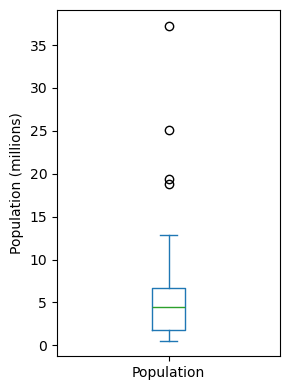

In [60]:
ax = (state["Population"] / 1000000).plot.box(figsize=(3, 4))
ax.set_ylabel("Population (millions)")

plt.tight_layout()
plt.show()

# Гистограма и таблица частот

# Метод cut для данных pandas разбивает набор данных на ячейки. Для этого метода есть ряд аргументов. Следующий код создает ячейки одинакового размера. Метод value_counts возвращает таблицу частот

In [63]:
binnedPopulation = pd.cut(state["Population"], 10)
binnedPopulation.value_counts()

Population
(526935.67, 4232659.0]      24
(4232659.0, 7901692.0]      14
(7901692.0, 11570725.0]      6
(11570725.0, 15239758.0]     2
(15239758.0, 18908791.0]     1
(18908791.0, 22577824.0]     1
(22577824.0, 26246857.0]     1
(33584923.0, 37253956.0]     1
(26246857.0, 29915890.0]     0
(29915890.0, 33584923.0]     0
Name: count, dtype: int64

# Частотная таблица численности населения по штатам

In [67]:
binnedPopulation.name = "binnedPopulation"
df = pd.concat([state, binnedPopulation], axis=1)
df = df.sort_values(by="Population")

groups = []
for group, subset in df.groupby(by="binnedPopulation", observed=False):
    groups.append({
        "BinRage": group,
        "Count": len(subset),
        "States": ",".join(subset.Abbreviation)
    })

pd.DataFrame(groups)

,BinRage,Count,States
0,"(526935.67, 4232659.0]",24,"WY,VT,ND,AK,SD,DE,MT,RI,NH,ME,HI,ID,NE,WV,NM,N..."
1,"(4232659.0, 7901692.0]",14,"KY,LA,SC,AL,CO,MN,WI,MD,MO,TN,AZ,IN,MA,WA"
2,"(7901692.0, 11570725.0]",6,"VA,NJ,NC,GA,MI,OH"
3,"(11570725.0, 15239758.0]",2,"PA,IL"
4,"(15239758.0, 18908791.0]",1,FL
5,"(18908791.0, 22577824.0]",1,NY
6,"(22577824.0, 26246857.0]",1,TX
7,"(26246857.0, 29915890.0]",0,
8,"(29915890.0, 33584923.0]",0,
9,"(33584923.0, 37253956.0]",1,CA


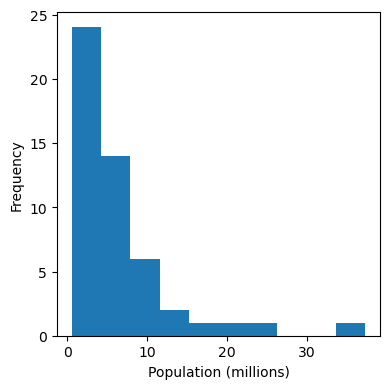

In [68]:
ax = (state["Population"] / 1000000).plot.hist(figsize=(4, 4))
ax.set_xlabel("Population (millions)")

plt.tight_layout()
plt.show()

## Оценки плотности
Плотность — это альтернатива гистограммам, которая может дать более глубокое представление о распределении точек данных. Используйте аргумент `bw_method` для управления гладкостью кривой плотности.

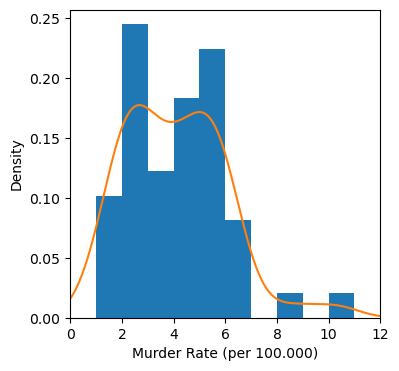

In [69]:
ax = state["Murder.Rate"].plot.hist(density=True, xlim=[0, 12], bins=range(1, 12), figsize=(4, 4))

state["Murder.Rate"].plot.density(ax=ax)
ax.set_xlabel("Murder Rate (per 100.000)")

plt.show()

# Изучение бинарных и категориальных данных

In [70]:
dfw = pd.read_csv(AIRPORT_DELAYS_CSV)
dfw

,Carrier,ATC,Weather,Security,Inbound
0,64263.16,84856.5,11235.42,343.15,118427.82


# выдать по процентам

In [71]:
100 * dfw / dfw.values.sum()

,Carrier,ATC,Weather,Security,Inbound
0,23.022989,30.400781,4.025214,0.122937,42.428079


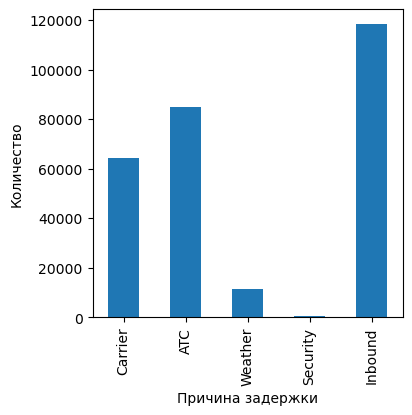

In [72]:
ax = dfw.transpose().plot.bar(figsize=(4, 4), legend=False)
ax.set_xlabel("Причина задержки")
ax.set_ylabel("Количество")

plt.show()

# Корреляция

In [73]:
sp500_sym = pd.read_csv(SP500_SECTORS_CSV)
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)

In [74]:
sp500_sym

,sector,sector_label,sub_sector,symbol
0,information_technology,Technology,data_processing_&_outsourced_services,ADS
1,information_technology,Technology,systems_software,CA
2,information_technology,Technology,systems_software,MSFT
3,information_technology,Technology,systems_software,RHT
4,information_technology,Technology,it_consulting_&_services,CTSH
...,...,...,...,...
512,health_care,Health Care,biotechnology,CELG
513,health_care,Health Care,biotechnology,GILD
514,health_care,Health Care,biotechnology,REGN
515,health_care,Health Care,biotechnology,VRTX


In [75]:
sp500_px

,ADS,CA,MSFT,RHT,CTSH,CSC,EMC,IBM,XRX,ALTR,...,WAT,ALXN,AMGN,BXLT,BIIB,CELG,GILD,REGN,VRTX,HSIC
1993-01-29,0.000000,0.060124,-0.022100,0.000000,0.000000,0.018897,0.007368,0.092165,0.259140,-0.007105,...,0.000000,0.000000,0.347160,0.000000,0.041670,0.000000,0.015564,1.750000,0.125000,0.000000
1993-02-01,0.000000,-0.180389,0.027621,0.000000,0.000000,0.018889,0.018425,0.115207,-0.100775,0.063893,...,0.000000,0.000000,-0.231440,0.000000,0.000000,-0.010410,0.007782,1.250000,0.125000,0.000000
1993-02-02,0.000000,-0.120257,0.035900,0.000000,0.000000,-0.075573,0.029482,-0.023041,0.028796,-0.014192,...,0.000000,0.000000,-0.115720,0.000000,0.000000,0.000000,-0.007792,-0.250000,0.000000,0.000000
1993-02-03,0.000000,0.060124,-0.024857,0.000000,0.000000,-0.151128,0.003689,-0.253454,-0.043190,-0.007105,...,0.000000,0.000000,-0.086790,0.000000,0.041670,-0.041670,-0.038919,-0.500000,0.062500,0.000000
1993-02-04,0.000000,-0.360770,-0.060757,0.000000,0.000000,0.113350,-0.022114,0.069862,0.000000,-0.007096,...,0.000000,0.000000,0.144650,0.000000,-0.041660,-0.031260,-0.046711,0.000000,0.062500,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-25,0.019989,-0.529999,-0.379997,0.080002,0.350003,-0.580002,-0.457999,-1.720001,-0.009936,0.039997,...,-2.500000,1.889999,-2.060012,0.150002,-1.630004,-0.990005,-2.250000,1.270019,-1.919998,-0.080002
2015-06-26,-1.299988,-0.330000,-0.390004,-1.820000,0.190003,0.330002,-0.328565,-0.769989,0.020000,0.000000,...,-0.070007,-2.380005,-1.390000,0.550004,-3.509979,-1.080002,-0.800003,-1.900024,-3.629997,0.440002
2015-06-29,-10.299988,-0.410000,-0.670002,-1.250000,-1.919998,-0.510002,-0.139999,-0.949997,-0.100000,-0.040001,...,-2.250000,-5.490005,-5.029999,0.090000,-8.290009,-1.209999,-2.419998,-9.620026,-3.770004,-2.479996
2015-06-30,-2.109986,-0.049999,-0.559997,-0.099999,-0.689999,-0.610001,0.239999,-1.330001,-0.200000,0.020001,...,-0.299988,0.270004,0.279999,-1.710001,0.390014,0.439995,-0.209999,-2.070007,-0.849999,-1.360001


# Корреляция между ежедневными финансовыми возвратами акций телекоммуникационных компаний

In [78]:
telecomSymbols = sp500_sym[sp500_sym["sector"] == "telecommunications_services"]["symbol"]

# filter for july 2012 through june 2015
telecom = sp500_px.loc[sp500_px.index >= "2012-07-01", telecomSymbols]
telecom.corr()
telecom

,T,CTL,FTR,VZ,LVLT
2012-07-02,0.422496,0.140847,0.070879,0.554180,-0.519998
2012-07-03,-0.177448,0.066280,0.070879,-0.025976,-0.049999
2012-07-05,-0.160548,-0.132563,0.055128,-0.051956,-0.180000
2012-07-06,0.342205,0.132563,0.007875,0.140106,-0.359999
2012-07-09,0.136883,0.124279,-0.023626,0.253943,0.180000
...,...,...,...,...,...
2015-06-25,0.049342,-1.600000,-0.040000,-0.187790,-0.330002
2015-06-26,-0.256586,0.039999,-0.070000,0.029650,-0.739998
2015-06-29,-0.098685,-0.559999,-0.060000,-0.504063,-1.360000
2015-06-30,-0.503298,-0.420000,-0.070000,-0.523829,0.199997


# Корреляция между финасовыми возвратами биржевых инвестиционных фондов (ETF)

In [79]:
etfs = sp500_px.loc[sp500_px.index > "2012-07-01", sp500_sym[sp500_sym["sector"] == "etf"]["symbol"]]
etfs.head()

,XLI,QQQ,SPY,DIA,GLD,VXX,USO,IWM,XLE,XLY,XLU,XLB,XTL,XLV,XLP,XLF,XLK
2012-07-02,-0.376098,0.096313,0.028223,-0.242796,0.419998,-10.40,0.000000,0.534641,0.028186,0.095759,0.098311,-0.093713,0.019076,-0.009529,0.313499,0.018999,0.075668
2012-07-03,0.376099,0.481576,0.874936,0.728405,0.490006,-3.52,0.250000,0.926067,0.995942,0.000000,-0.044686,0.337373,0.000000,0.000000,0.129087,0.104492,0.236462
2012-07-05,0.150440,0.096313,-0.103487,0.149420,0.239991,6.56,-0.070000,-0.171848,-0.460387,0.306431,-0.151938,0.103086,0.019072,-0.142955,-0.073766,-0.142490,0.066211
2012-07-06,-0.141040,-0.491201,0.018819,-0.205449,-0.519989,-8.80,-0.180000,-0.229128,0.206706,0.153214,0.080437,0.018744,-0.429213,-0.095304,0.119865,0.066495,-0.227003
2012-07-09,0.244465,-0.048160,-0.056445,-0.168094,0.429992,-0.48,0.459999,-0.190939,-0.234892,-0.201098,-0.035751,-0.168687,0.000000,0.352630,-0.064548,0.018999,0.009457


# Из-за большого количества столбцов в этой таблице просмотр корреляционной матрицы громоздок, и удобнее изобразить корреляцию в виде тепловой карты. Пакет seaborn обеспечивает удобную реализацию для тепловых карт.

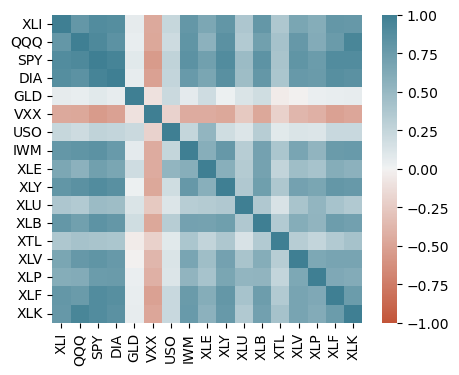

In [80]:
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.heatmap(etfs.corr(), vmin=-1, vmax=1, 
                cmap=sns.diverging_palette(20, 220, as_cmap=True),
                ax=ax)

plt.show()

# степень заливки говорит о силе корреляции биржевых инвестиционных фондов, диапазон -1, 1

# Тепловая карта выше работает, когда у вас есть цвет. Для изображений в оттенках серого, как в книге, нам нужно визуализировать также и направление. Следующий код показывает силу корреляции с использованием эллипсов.

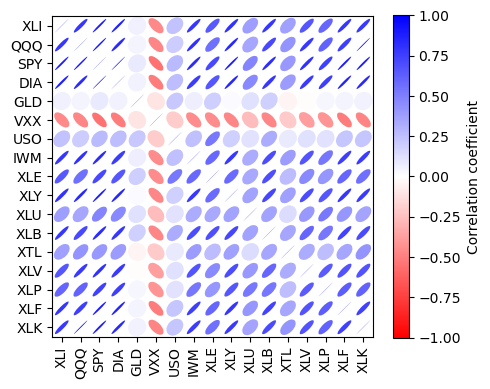

In [81]:
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

def plot_corr_ellipses(data, figsize=None, **kwargs):
    ''' https://stackoverflow.com/a/34558488 '''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'aspect':'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel() + 0.01
    h = 1 - np.abs(M).ravel() - 0.01
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           norm=Normalize(vmin=-1, vmax=1),
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec, ax

m, ax = plot_corr_ellipses(etfs.corr(), figsize=(5, 4), cmap='bwr_r')
cb = plt.colorbar(m, ax=ax)
cb.set_label('Correlation coefficient')

plt.tight_layout()
plt.show()

# Диаграммы рассеяния
Простые диаграммы рассеяния поддерживаются _pandas_. Указание маркера как `$\u25EF$` использует открытый круг для каждой точки.

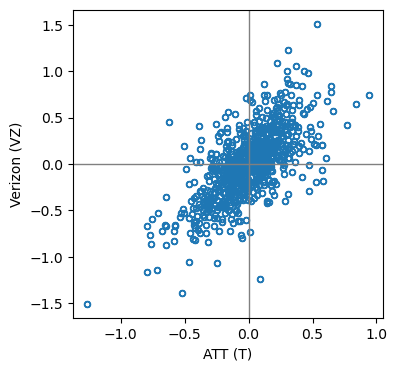

In [82]:
ax = telecom.plot.scatter(x="T", y="VZ", figsize=(4, 4), marker="$\u25EF$")
ax.set_xlabel("ATT (T)")
ax.set_ylabel("Verizon (VZ)")
ax.axhline(0, color="grey", lw=1)
ax.axvline(0, color="grey", lw=1)

plt.show()

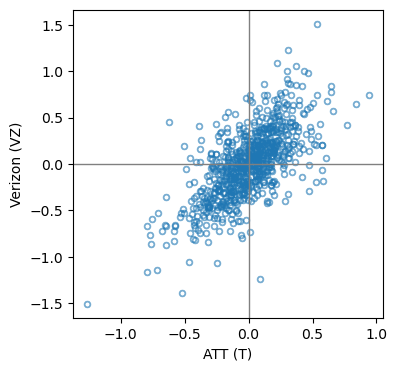

In [86]:
ax = telecom.plot.scatter(x="T", y="VZ", figsize=(4, 4), marker="$\u25EF$", alpha=0.5)
ax.set_xlabel("ATT (T)")
ax.set_ylabel("Verizon (VZ)")
ax.axhline(0, color="grey", lw=1)
ax.axvline(0, color="grey", lw=1)

plt.show()

# Исследование 2 и более переменных

In [89]:
kc_tax = pd.read_csv(KC_TAX_CSV)
kc_tax0 = kc_tax.loc[
(kc_tax.TaxAssessedValue < 750000) &
(kc_tax.SqFtTotLiving > 100) &
(kc_tax.SqFtTotLiving < 3500), :
]
kc_tax0.shape

(432693, 3)

# Сетка из шестиугольных корзин и контуры (сопоставление числовых данных с числовыми данными на графике)

Если число точек данных становится большим, то диаграммы рассеяния больше не будут иметь смысла. Здесь более полезны методы, визуализирующие плотности. Метод `hexbin` для фреймов данных _pandas_ является одним из мощных подходов.

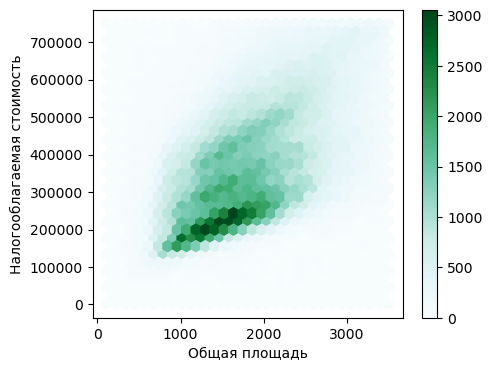

In [91]:
ax = kc_tax0.plot.hexbin(x="SqFtTotLiving", y="TaxAssessedValue", gridsize=30, sharex=False, figsize=(5, 4))
ax.set_xlabel("Общая площадь")
ax.set_ylabel("Налогооблагаемая стоимость")

plt.show()

_seaborn_ kdeplot — это двумерное расширение графика плотности. Расчет двумерной плотности для полного набора данных занимает несколько минут. Достаточно создать визуализацию с меньшей выборкой набора данных. При 10 000 точек данных создание графика занимает всего несколько секунд. Хотя некоторые детали могут быть утеряны, общая форма сохраняется.


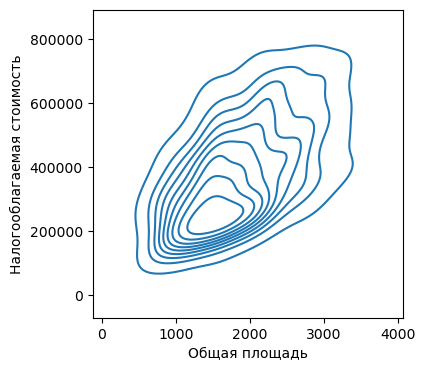

In [92]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(data=kc_tax0.sample(1000), x="SqFtTotLiving", y="TaxAssessedValue", ax=ax)
ax.set_xlabel("Общая площадь")
ax.set_ylabel("Налогооблагаемая стоимость")

plt.show()

# 2 категориальные переменные

In [96]:
lc_loans = pd.read_csv(LC_LOANS_CSV)
lc_loans

,status,grade
0,Fully Paid,B
1,Charged Off,C
2,Fully Paid,C
3,Fully Paid,C
4,Current,B
...,...,...
450956,Current,D
450957,Current,D
450958,Current,D
450959,Current,D


In [97]:
crosstab = lc_loans.pivot_table(index="grade", columns="status", aggfunc=lambda x: len(x), margins=True)
crosstab

status,Charged Off,Current,Fully Paid,Late,All
grade,,,,,
A,1562,50051,20408,469,72490
B,5302,93852,31160,2056,132370
C,6023,88928,23147,2777,120875
D,5007,53281,13681,2308,74277
E,2842,24639,5949,1374,34804
F,1526,8444,2328,606,12904
G,409,1990,643,199,3241
All,22671,321185,97316,9789,450961


# Таблица сопряженности уровня ссуд и их состояния

In [98]:
df = crosstab.copy().loc["A":"G",:].astype(float)
df.loc[:, "Charged Off":"Late"] = df.loc[:, "Charged Off":"Late"].div(df["All"], axis=0)
df["All"] = df["All"] / sum(df["All"])
df

status,Charged Off,Current,Fully Paid,Late,All
grade,,,,,
A,0.021548,0.690454,0.281528,0.006470,0.160746
B,0.040054,0.709013,0.235401,0.015532,0.293529
C,0.049828,0.735702,0.191495,0.022974,0.268039
D,0.067410,0.717328,0.184189,0.031073,0.164708
E,0.081657,0.707936,0.170929,0.039478,0.077177
F,0.118258,0.654371,0.180409,0.046962,0.028614
G,0.126196,0.614008,0.198396,0.061401,0.007187


# Категориальные и числовые данные

сравниваем каким образом процент задержек авиарейсов варьируется среди авиакомпаний

In [99]:
airline_stats = pd.read_csv(AIRLINE_STATS_CSV)
airline_stats.head()

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,airline
0,8.153226,1.971774,0.762097,American
1,5.959924,3.706107,1.585878,American
2,7.157270,2.706231,2.026706,American
3,12.100000,11.033333,0.000000,American
4,7.333333,3.365591,1.774194,American


# Коробчатая диаграмма процента задержек

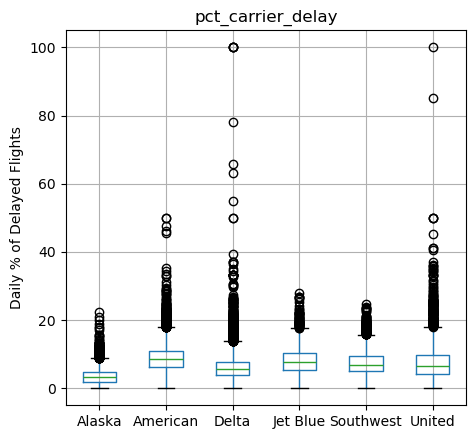

In [100]:
ax = airline_stats.boxplot(by="airline", column="pct_carrier_delay", figsize=(5, 5))
ax.set_xlabel("")
ax.set_ylabel("Daily % of Delayed Flights")
plt.suptitle("")

plt.show()

# Скрипичный график (violinplot)

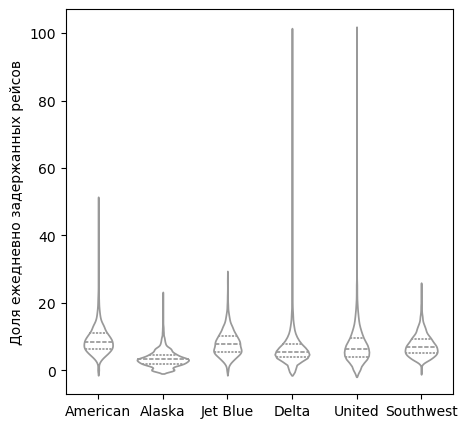

In [101]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.violinplot(data=airline_stats, x="airline", y="pct_carrier_delay", ax=ax, inner="quartile", color="white")

ax.set_xlabel("")
ax.set_ylabel("Доля ежедневно задержанных рейсов")

plt.show()

# Визуализация многочисленных переменных

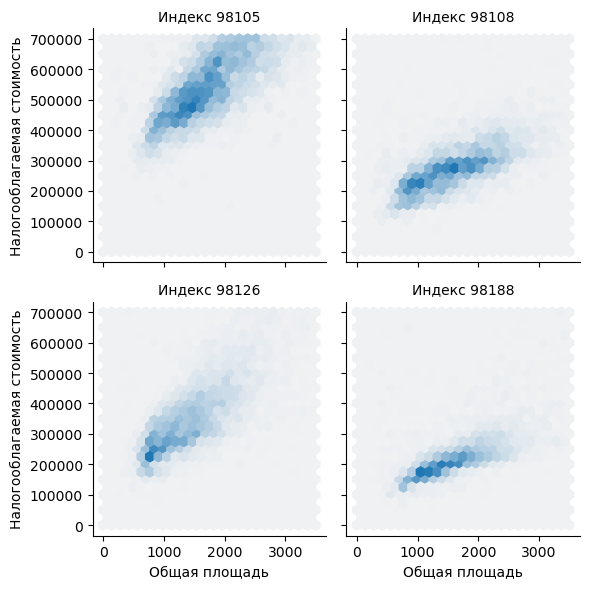

In [103]:
zip_codes = [98188, 98105, 98108, 98126]
kc_tax_zip = kc_tax0.loc[kc_tax0.ZipCode.isin(zip_codes),:]
kc_tax_zip

def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)

g = sns.FacetGrid(kc_tax_zip, col='ZipCode', col_wrap=2)
g.map(hexbin, 'SqFtTotLiving', 'TaxAssessedValue', 
      extent=[0, 3500, 0, 700000])
g.set_axis_labels('Общая площадь', 'Налогооблагаемая стоимость')
g.set_titles('Индекс {col_name:.0f}')

plt.tight_layout()
plt.show()

Ключевая идея разведывательного анализа данных заключается в том, что первый и самый важный шаг в любом проекте, основанном на данных, состоит в том, чтобы посмотреть на данные. Благодаря обобщению и визуализации данных можно получить ценное интуитивное понимание проекта